# Map-match a track on a network

<div class="alert alert-block alert-warning" style="padding:1em">The function to map-match a track on a network is: <b><i>mapOnNetwork</i></b>.</div>

<br/>
<div style='text-align:justify'>In this tutorial, points are map-matched to a reference road network by applying the Hidden Markov Models algorithm developed by Newson and Krumm (Newson & Krumm, 2009). The algorithm, for each point to match, takes into account the points before and after, thus the consistency of the routes is fulﬁlled.</div>

<br/>
<div class="alert alert-block alert-info" style='text-align:justify'>
    <b>Reference:</b><br/>Newson, P., & Krumm, J. (2009). <i>Hidden Markov map matching through noise and sparseness.</i> Proceedings of the 17th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, GIS ‘09, ACM, New York, NY, USA, pp. 336–343. <a href='https://doi.org/10.1145/1653771.1653818'>https://doi.org/10.1145/1653771.1653818</a></div>

## Let's start by importing tracklib library

In [1]:
import matplotlib.pyplot as plt
import os
import sys

#-------------------------------------------------------
# 1. [if tracklib is not installed using pip] add tracklib's local path in the python path
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# 2. Import
import tracklib as trk

## Loading GPS points

Data points are stored in a csv file. The first line contained header with names of columns:  
<div style='margin-left:4em'><i>X,Y,track_fid,track_seg_id,track_seg_point_id,ele,time</i></div>

Coordinates is provided in Geographic system reference and separtor caracter is the comma. The time's format is: <i>“4Y/2M/2D 2h:2m:2s”</i>

In [2]:
import matplotlib.pyplot as plt

# Specify time format
trk.ObsTime.setReadFormat("4Y/2M/2D 2h:2m:2s")

# local file path
trackpath = '../../../data/csv/22245.csv'

# Loading GPS points
param = trk.TrackFormat({'ext': 'CSV', 'id_E':0, 'id_N':1, 'id_U':2, 'id_T':3, 'srid': "Geo", 'header': 1, 'separator': ','})
trace = trk.TrackReader.readFromFile(trackpath, param, verbose=False)

# Transform geographic coordinates in local projection
trace.toENUCoordsIfNeeded()

# Display a little summary of information of the GPS track:
trace.summary()

-------------------------------------
GPS track #22245 of user 0:
-------------------------------------
  Nb of pt(s):   52
  Ref sys id   : ENU
  Starting at  : 12/07/2019 15:42:35
  Ending at    : 12/07/2019 16:48:16
  Duration     : 3941.000 s
  Length       : 1325.369 m
-------------------------------------



## Loading the road network

Data network are stored in a csv file. The first line contained header with names of columns:  
<div style='margin-left:4em'><i>WKT,link_id,source,target,direction</i></div>



In [3]:
netpath = '../../../data/network/network-utgtrack-22245.csv'
network = trk.NetworkReader.readFromFile(netpath, formatfile='VTT', verbose=False)

# Transform geographic coordinates in local projection
network.toENUCoords(trace.base)

# Print number of edges and nodes of the network
print ('nb edges=', len(network.EDGES))
print ('nb nodes=', len(network.NODES))
print ('total length=', network.totalLength())

nb edges= 288
nb nodes= 216
total length= 19386.544826479814


## Prepare and launch the map matching process

In [4]:
si = trk.SpatialIndex(network, verbose=False)
network.spatial_index = si



In [5]:
# computes all distances between pairs of nodes
network.prepare()



  7% (17 of 216) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:00

Map-matching preparation...


100% (216 of 216) |######################| Elapsed Time: 0:00:00 Time:  0:00:000:00


In [6]:
# Map track on network
trk.mapOnNetwork(trace, network, search_radius=25, debug=False)



## Display results 

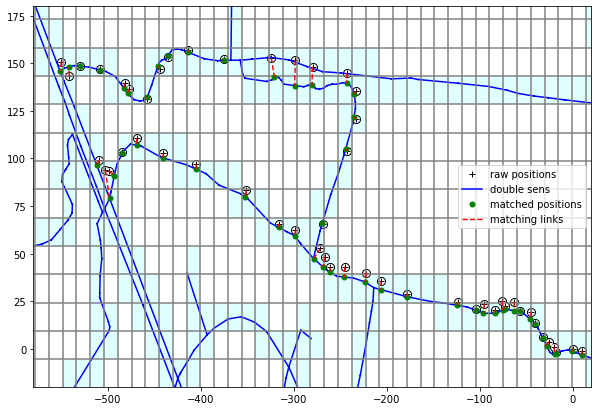

In [7]:
plt.figure(figsize = (10, 7))

# emprise = trace.bbox()
plt.xlim([-580, 20])
plt.ylim([-20, 180])

trace.plotAsMarkers(append=True, label='raw positions')
network.plot('b-', '', '', '', 1.5, plt)
si.plot(base=False, append=True)

for k in range(len(trace)):
    xmm = trace["hmm_inference", k][0].getX()
    ymm = trace["hmm_inference", k][0].getY()
    plt.plot(xmm, ymm, 'go', markersize=5, label='matched positions' if k == 0 else "")
    X = [trace[k].position.getX(), xmm]
    Y = [trace[k].position.getY(), ymm]
    plt.plot(X, Y, "r--", linewidth=1.4, label='matching links' if k == 0 else "")
    trace[k].position.setX(trace["hmm_inference", k][0].getX())
    trace[k].position.setY(trace["hmm_inference", k][0].getY())

plt.legend()